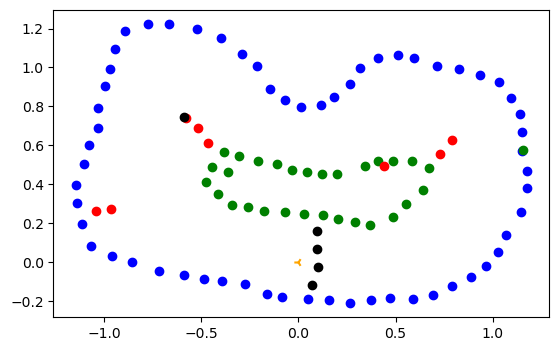

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from shapely.geometry import Polygon
from shapely.geometry import Point
from magic import ordinator

with open(r"SLAM20240121_162038.pickle", "rb") as input_file:
    e = pickle.load(input_file)

positions = e['positions']
ids = e['ids']

for i, pos_zip in enumerate(zip(positions, ids)):
    col = pos_zip[1] % 3
    if col == 0:
        col2 = 'green'
    elif col == 1:
        col2 = 'red'
    elif col == 2:
        col2 = 'blue'
    if pos_zip[1] < 100:
        col2 = 'black'
    plt.scatter(*pos_zip[0], color=col2)

plt.scatter(0, 0, color='orange', marker='3',)
plt.gca().set_aspect('equal')
plt.show()

positions_array = np.array(positions)
positions_array = np.array(positions)

mask_external = (ids % 3 == 2) & (ids >= 100) & (ids <= 1000)
mask_internal = (ids % 3 == 0) & (ids >= 100) & (ids <= 1000)

ids_external = ids[mask_external]
ids_internal = ids[mask_internal]

positions_external = positions_array[mask_external]
positions_internal = positions_array[mask_internal]


pos_list_ext = [pos for pos in positions_external]
pos_list_int = [pos for pos in positions_internal]

In [2]:
external_ordered = np.array(ordinator(pos_list_ext))
internal_ordered = np.array(ordinator(pos_list_int))

Missing 2 nodes to close the polygon; min_dist = 0.6166924746522137


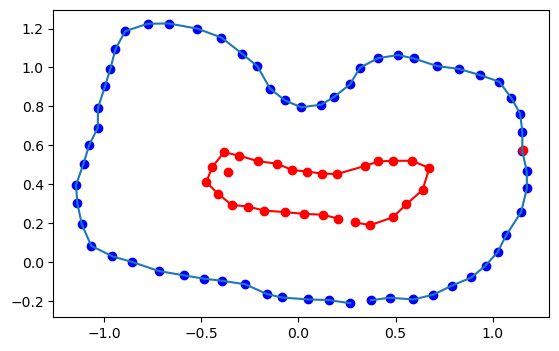

In [3]:
plt.plot(external_ordered[:, 0], external_ordered[:, 1])
for i in positions_external:
    plt.scatter(*i, c='blue')
plt.plot(internal_ordered[:, 0], internal_ordered[:, 1], color='red')
for i in positions_internal:
    plt.scatter(*i, c='red')
plt.gca().set_aspect('equal')
plt.show()

In [4]:
max_x=np.max(external_ordered[:,0])
max_y=np.max(external_ordered[:,1])
min_x=np.min(external_ordered[:,0])
min_y=np.min(external_ordered[:,1])

In [5]:
delta_x=max_x-min_x
delta_y=max_y-min_y

In [6]:
center_x=min_x+delta_x/2
center_y=min_y+delta_y/2

In [7]:
spatial_step=0.05

In [8]:
n_x = int(delta_x/spatial_step/1.5)
n_y = int(delta_y/spatial_step/1.5)

In [9]:
ext_ordered_poly = Polygon(external_ordered)
int_ordered_poly = Polygon(internal_ordered)

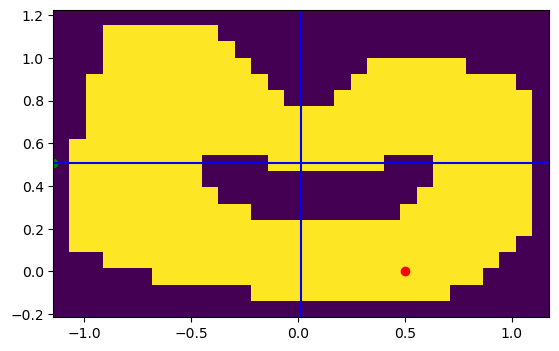

In [10]:
x = np.linspace(min(np.concatenate([external_ordered[:, 0], internal_ordered[:, 0]])), max(
    np.concatenate([external_ordered[:, 0], internal_ordered[:, 0]])), n_x)
y = np.linspace(min(np.concatenate([external_ordered[:, 1], internal_ordered[:, 1]])), max(
    np.concatenate([external_ordered[:, 1], internal_ordered[:, 1]])), n_y)
X, Y = np.meshgrid(x, y)

# Create a mask where the pixels inside the first circle and outside the second circle are set to 1, and all others are set to 0
mask = np.array([[ext_ordered_poly.contains(Point(x[i], y[j])) and not int_ordered_poly.contains(
    Point(x[i], y[j])) for i in range(len(x))] for j in range(len(y))])

plt.imshow(mask, interpolation='nearest', origin='lower',
           extent=[min(x), max(x), min(y), max(y)])
plt.axhline(center_y, color='blue')
plt.axvline(center_x, color='blue')
plt.scatter(min_x, center_y, color='green')
plt.scatter(0.5, 0, color='red',)
# plt.scatter(center_x, center_y, color='blue')
plt.show()

In [11]:
index_x = int(abs(min_x-0.5)/spatial_step/1.5)
index_y = int(abs(min_y-0)/spatial_step/1.5)

In [12]:
index_y, index_x

(2, 21)

In [13]:
mask[index_y,index_x]=False

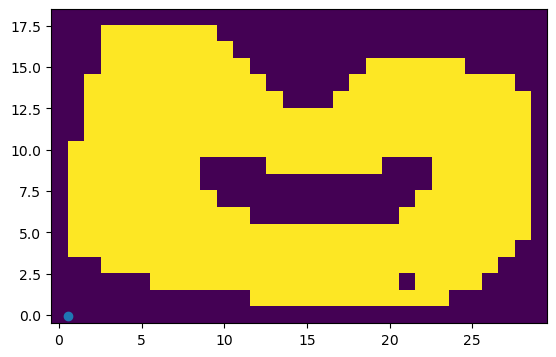

In [14]:
plt.imshow(mask, interpolation='nearest', origin='lower')
plt.scatter(x[index_x], y[index_y])

In [15]:
# function to find quadrand
def quadrant(position, max_x, max_y, min_x, min_y):
    center_y = min_x+(max_y-min_y)/2
    center_x = min_y+(max_x-min_x)/2
    x, y = position[0:2]
    if x >= center_x and y < center_y:
        return 1
    elif x >= center_x and y >= center_y:
        return 2
    elif x < center_x and y >= center_y:
        return 3
    elif x < center_x and y < center_y:
        return 4

In [16]:
# function heuristics
def distance_from_arrival(position, arrival, max_x, max_y, min_x, min_y, visited_quadrant):
    quadrant_temp = quadrant(position, max_x, max_y, min_x, min_y)

    if quadrant_temp not in visited_quadrant:
        visited_quadrant.append(quadrant_temp)

    distance = 0

    delta_x = max_x-min_x
    delta_y = max_y-min_y

    center_y = min_x+delta_y/2
    center_x = min_y+delta_x/2

    x, y = position[0:2]
    x_arrival, y_arrival = arrival[0:2]

    if quadrant_temp == 1:
        # variable 1
        distance += abs(max_x-x)+abs(center_y-y)
        # 2 & 3
        distance += abs(delta_y)
        distance += abs(delta_x)
        # 4
        distance += abs(min_x)
        distance += abs(center_y)
    elif quadrant_temp == 2:
        # 2 variable
        distance += abs(max_y-y)+abs(x-center_x)
        # 3
        distance += delta_x/2
        distance += delta_y/2
        # 4
        distance += abs(min_x)
        distance += abs(center_y)

    elif quadrant_temp == 3:
        # 3 variable
        distance += abs(x-min_x)+abs(y-center_y)
        # 4
        distance += abs(min_x)
        distance += abs(center_y)
    elif quadrant_temp == 4:
        if 2 in visited_quadrant:
            distance += abs(x)+abs(y)
        else:
            distance += abs(x-max_x) + abs(y-center_y)

    return distance, visited_quadrant